# Определение возраста покупателей

## Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

**ЦЕЛЬ:** Построить модель, которая по фотографии определит приблизительный возраст человека. Набор данных состоит из фотографий людей `file_name`	с указанием возраста `real_age`.

# Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.shape

(7591, 2)

In [5]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

In [24]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


<AxesSubplot:xlabel='real_age', ylabel='Density'>

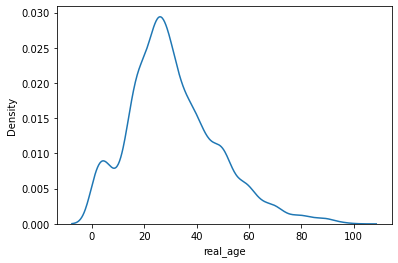

In [14]:

sns.kdeplot(data=labels, x='real_age')

<AxesSubplot:>

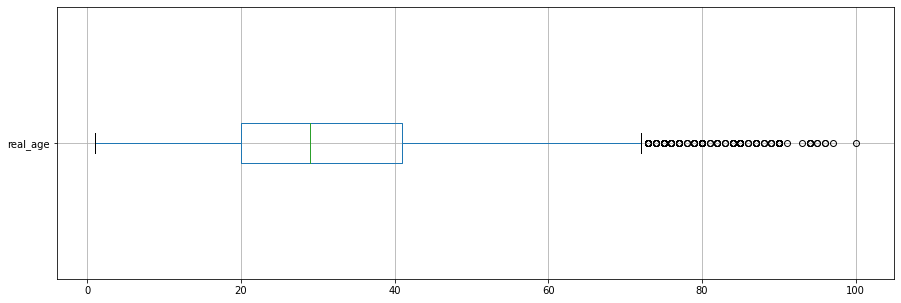

In [10]:
labels.boxplot(vert=False, figsize=(15,5))

In [25]:
train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        width_shift_range=0.2, height_shift_range=0.2,
        rescale=1/255.)#ImageDataGenerator(rescale=1/255.)#,horizontal_flip=True,  vertical_flip=True, width_shift_range=0.2, height_shift_range=0.2, rotation_range=90
                                   

In [26]:
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=32,
    class_mode='raw',
    seed=12345)

features, target = next(train_datagen_flow)

Found 7591 validated image filenames.


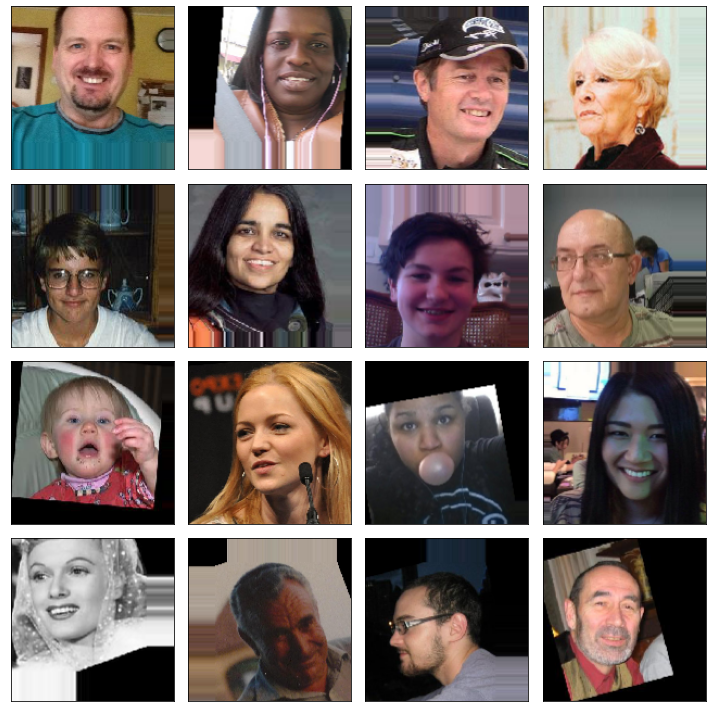

In [27]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Маленький предвывод))
В наборе 7591 объектов, 2 столбца, один из которых содержит фотографии, второй реальный возраст человека. В наборе присутствуют как цветные, так и черно-белые фото. К тому же фото сделаны с разных ракурсов, что может снизить качество обучения

В распределении наблюдается 2 пика(демографический кризис?🤔🤔) возможно выборка детских фото собиралась и присоединялась отдельно

Средний возраст выборки 31 год. 
все возраста расположены в интервале 1-100, основная часть находится в диапозоне 10 - 50. Распределение близко к нормальному
"Усатый"  говорит, что все что после 72 - выбросы. Тем не менее, считаю, что нельзя просто исключить эту часть, т.к не ссможем распознавать возрастных людей (да и в принципе логично, что чем больше возраст, тем ниже численность такой группы)

Пропусков в данных не обнаружено 

Для формирования тренировочных признаков были добавлены фото с растяжением по вертикали и горизонтали, а также отраженные по горизонтали 

## Обучение модели

(Код в этом разделе запускался в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
      df = pd.read_csv(path + 'labels.csv')
      train_datagen = ImageDataGenerator(rescale=1./255,
                                         horizontal_flip=True,
                                         width_shift_range=0.2, height_shift_range=0.2,
                                         validation_split=0.25
                                         )
      train_datagen_flow = train_datagen.flow_from_dataframe(
              dataframe = df,
              directory = path + 'final_files',
              x_col = 'file_name',
              y_col = 'real_age',
              class_mode = 'raw',
              target_size = (150,150),
              batch_size = 32,
              subset='training',
              seed=12345
              )
      return train_datagen_flow
 
def load_test(path):
      df = pd.read_csv(path + 'labels.csv')
      test_datagen = ImageDataGenerator(rescale=1./255,
                                        validation_split=0.25
                                        )
      test_datagen_flow = test_datagen.flow_from_dataframe(
              dataframe = df,
              directory = path + 'final_files',
              x_col = 'file_name',
              y_col = 'real_age',
              class_mode = 'raw',
              target_size = (150,150),
              batch_size = 32,
              subset='validation',
              seed=12345
              )
      return test_datagen_flow
 

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
   
    model = Sequential()
    optimizer = Adam(lr=0.001)
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(32, activation='relu'))
    #model.add(Dense(12, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae']) #'sparse_categorical_crossentropy'
    return model


def train_model(model, train_data, test_data, batch_size=32, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

## Результаты

```

Epoch 1/20
2022-07-24 16:29:03.147103: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-24 16:29:03.458999: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 69s - loss: 233.7533 - mae: 11.5757 - val_loss: 431.1535 - val_mae: 15.7042
Epoch 2/20
178/178 - 61s - loss: 173.8034 - mae: 10.1203 - val_loss: 292.0078 - val_mae: 12.8133
Epoch 3/20
178/178 - 61s - loss: 153.6343 - mae: 9.5158 - val_loss: 281.3151 - val_mae: 13.1498
Epoch 4/20
178/178 - 60s - loss: 142.9955 - mae: 9.0896 - val_loss: 235.7616 - val_mae: 11.9583
Epoch 5/20
178/178 - 60s - loss: 135.3606 - mae: 8.8566 - val_loss: 212.4528 - val_mae: 10.4818
Epoch 6/20
178/178 - 60s - loss: 122.7523 - mae: 8.4605 - val_loss: 143.8465 - val_mae: 9.0929
Epoch 7/20
178/178 - 60s - loss: 117.9922 - mae: 8.2605 - val_loss: 293.4725 - val_mae: 13.8657
Epoch 8/20
178/178 - 60s - loss: 111.3877 - mae: 8.0160 - val_loss: 190.9493 - val_mae: 10.3548
Epoch 9/20
178/178 - 60s - loss: 111.1196 - mae: 8.0191 - val_loss: 113.2073 - val_mae: 8.0974
Epoch 10/20
178/178 - 60s - loss: 103.1629 - mae: 7.6778 - val_loss: 151.1955 - val_mae: 9.4585
Epoch 11/20
178/178 - 61s - loss: 99.2773 - mae: 7.6136 - val_loss: 243.9381 - val_mae: 12.1697
Epoch 12/20
178/178 - 61s - loss: 100.1225 - mae: 7.5567 - val_loss: 169.2161 - val_mae: 9.8899
Epoch 13/20
178/178 - 61s - loss: 86.9924 - mae: 7.0659 - val_loss: 180.8308 - val_mae: 9.7675
Epoch 14/20
178/178 - 60s - loss: 88.4891 - mae: 7.1085 - val_loss: 209.1860 - val_mae: 10.5162
Epoch 15/20
178/178 - 61s - loss: 93.3506 - mae: 7.2950 - val_loss: 176.8300 - val_mae: 9.9361
Epoch 16/20
178/178 - 60s - loss: 85.6028 - mae: 7.0084 - val_loss: 112.9932 - val_mae: 8.3096
Epoch 17/20
178/178 - 59s - loss: 83.9146 - mae: 6.9470 - val_loss: 119.3921 - val_mae: 8.1027
Epoch 18/20
178/178 - 60s - loss: 75.9681 - mae: 6.6320 - val_loss: 149.0484 - val_mae: 9.3730
Epoch 19/20
178/178 - 60s - loss: 76.7956 - mae: 6.6413 - val_loss: 137.7681 - val_mae: 8.8735
Epoch 20/20
178/178 - 60s - loss: 71.7901 - mae: 6.4182 - val_loss: 91.7732 - val_mae: 7.1714
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 91.7732 - mae: 7.1714
Test MAE: 7.1714



```

## Анализ обученной модели

Путем подбора гиперпараметров и архитектуры сети наилучший результ MAE: 7.1714 был получен при наличии двух скрытых слоев и 20 эпох обучения. Вкачестве фунции потерь использовалась среднеквадратическая ошибка, функия активации - relu

Достигнутые результаты говорят о том, что модель справляется с поставленной задачей. Чтобы улучшить результаты, можно попробовать увеличить численность фото только для возрастных людей, отобрать анфас фото, без ротации изображения